* To check averaged Coriolis effect over a strong wind period in Jan.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import matplotlib.dates as md
import wind
import pandas as pd
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2.5})

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [3]:
## load grid_T model results
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')
jannof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_T.nc')

In [4]:
## load grid_U model results
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')
jannof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_U.nc')

In [8]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [6]:
def Salinity(grid_T1,grid_T2,t1,t2,colormap,dep,cmin = -6,cmax = 6,ave = False):
    """ surface salinity distribution"""
    fig,axs = plt.subplots(1,3,figsize=(20,6))
    theta = np.pi*29/180
    S = {};U = {};V= {}
    for gridT,run, ax in zip([grid_T1,grid_T2],['all','nof'],[axs[0],axs[1]]):
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        if ave ==False:
            S[run] =gridT.variables['vosaline'][t1,0]
            S[run] = np.ma.masked_values(S[run],0)
        else:
            S[run] =np.ma.masked_values(np.nanmean(gridT.variables['vosaline'][t1:t2+1,0],axis = 0),0)
            
        mesh=ax.pcolormesh(lon,lat,S[run],vmin =0,vmax = 33,cmap=colormap) 
        cbar = fig.colorbar(mesh,ax = ax)
        cbar.set_label('Practical Salinity')

        S_thre = 24.7
        CS3 = ax.contour(lon[:],lat[:],S[run], levels = [S_thre], colors='k',linewidths=(3,))
        plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
        ax.set_ylim([48.9,49.5])
        ## add minimum salinity plot if available
    sal_diff = S['all'] - S['nof']
    ax = axs[2]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    cbar = fig.colorbar(mesh,ax = ax)
    cbar.set_label('Difference of Practical Salinity')
    SS,W = determine_plume_method2_onlysalinity(grid_T1,t1,t2+1,dep)
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_xticks([-124,-123.6,-123.2,-122.8])
    ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
    ax.set_ylim([48.9,49.5])

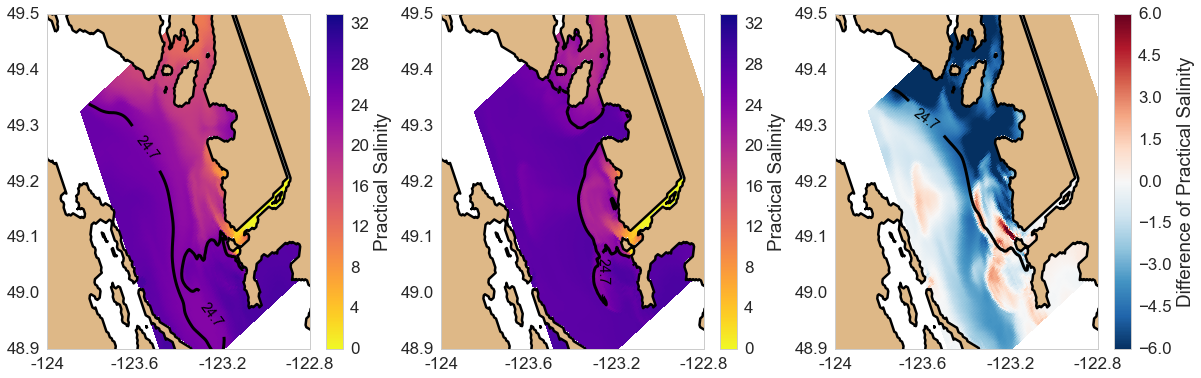

In [9]:
t1 = 624
t2 = 671
Salinity(janall_T,jannof_T,t1,t2,'plasma_r',0)

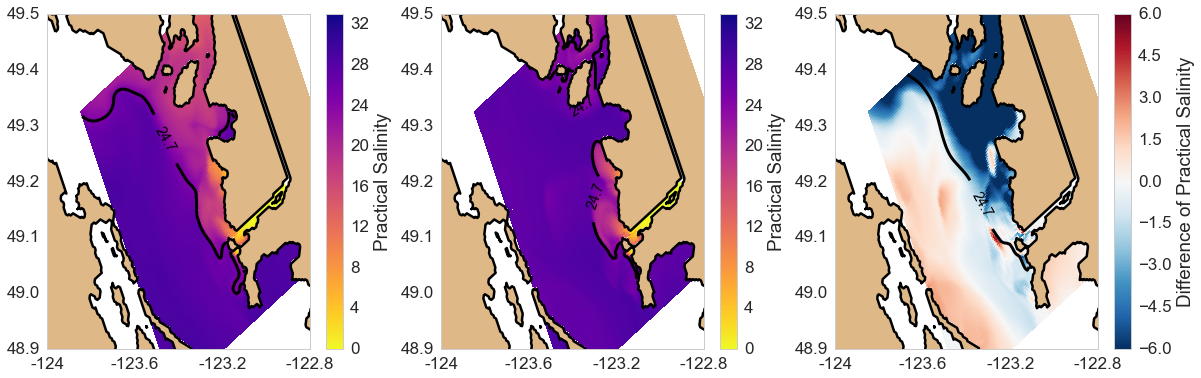

In [10]:
t1 = 384
t2 = 455
Salinity(janall_T,jannof_T,t1,t2,'plasma_r',0)